In [12]:
# Configuration step (Please run it before the code!)
import numpy as np
import sys, obspy, os
import matplotlib.pyplot as plt

from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth as gps2DistAzimuth # depends on obspy version; this is for v1.1.0
#from obspy.core.util import gps2DistAzimuth

#from PIL import Image
import requests
from io import BytesIO

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Functions
# collection of functions used in noise correlation processing

def normalize(tr, clip_factor=6, clip_weight=10, norm_win=None, norm_method="1bit"): 
    
    if norm_method == 'clipping':
        lim = clip_factor * np.std(tr.data)
        tr.data[tr.data > lim] = lim
        tr.data[tr.data < -lim] = -lim

    elif norm_method == "clipping_iter":
        lim = clip_factor * np.std(np.abs(tr.data))
        
        # as long as still values left above the waterlevel, clip_weight
        while tr.data[np.abs(tr.data) > lim] != []:
            tr.data[tr.data > lim] /= clip_weight
            tr.data[tr.data < -lim] /= clip_weight

    elif norm_method == 'ramn':
        lwin = tr.stats.sampling_rate * norm_win
        st = 0                                               # starting point
        N = lwin                                             # ending point

        while N < tr.stats.npts:
            win = tr.data[st:N]

            w = np.mean(np.abs(win)) / (2. * lwin + 1)
            
            # weight center of window
            tr.data[st + lwin / 2] /= w

            # shift window
            st += 1
            N += 1

        # taper edges
        taper = get_window(tr.stats.npts)
        tr.data *= taper

    elif norm_method == "1bit":
        tr.data = np.sign(tr.data)
        tr.data = np.float32(tr.data)

    return tr


def get_window(N, alpha=0.2):

    window = np.ones(N)
    x = np.linspace(-1., 1., N)
    ind1 = (abs(x) > 1 - alpha) * (x < 0)
    ind2 = (abs(x) > 1 - alpha) * (x > 0)
    window[ind1] = 0.5 * (1 - np.cos(np.pi * (x[ind1] + 1) / alpha))
    window[ind2] = 0.5 * (1 - np.cos(np.pi * (x[ind2] - 1) / alpha))
    return window


def whiten(tr, freqmin, freqmax):
    
    nsamp = tr.stats.sampling_rate
    
    n = len(tr.data)
    if n == 1:
        return tr
    else: 
        frange = float(freqmax) - float(freqmin)
        print(frange)
        nsmo = int(np.fix(min(0.01, 0.5 * (frange)) * float(n) / nsamp))
        print(nsmo)
        f = np.arange(n) * nsamp / (n - 1.)
        print(f)
        JJ = ((f > float(freqmin)) & (f<float(freqmax))).nonzero()[0]
        print(JJ)
        # signal FFT
        FFTs = np.fft.fft(tr.data)
        FFTsW = np.zeros(n) + 1j * np.zeros(n)

        # Apodization to the left with cos^2 (to smooth the discontinuities)
        smo1 = (np.cos(np.linspace(np.pi / 2, np.pi, nsmo+1))**2)
        FFTsW[JJ[0]:JJ[0]+nsmo+1] = smo1 * np.exp(1j * np.angle(FFTs[JJ[0]:JJ[0]+nsmo+1]))

        # boxcar
        FFTsW[JJ[0]+nsmo+1:JJ[-1]-nsmo] = np.ones(len(JJ) - 2 * (nsmo+1))\
        * np.exp(1j * np.angle(FFTs[JJ[0]+nsmo+1:JJ[-1]-nsmo]))

        # Apodization to the right with cos^2 (to smooth the discontinuities)
        smo2 = (np.cos(np.linspace(0., np.pi/2., nsmo+1.))**2.)
        espo = np.exp(1j * np.angle(FFTs[JJ[-1]-nsmo:JJ[-1]+1]))
        FFTsW[JJ[-1]-nsmo:JJ[-1]+1] = smo2 * espo

        whitedata = 2. * np.fft.ifft(FFTsW).real
        
        tr.data = np.require(whitedata, dtype="float32")

        return tr


def correlateNoise(st, stations, corrwin):

    print ('correlating stations', (stations[0], stations[1]))

    # initialize sliding timewindow (length = corrwin) for correlation
    # start 1 corrwin after the start to account for different stream lengths
    timewin = st.select(station=stations[1])[0].stats.starttime + corrwin
    print(timewin)
    # loop over timewindows 
    # stop 1 corrwin before the end to account for different stream lengths
    print(st.select(station=stations[0])[-1].stats.endtime - 2*corrwin)
    #def
    #while timewin < st.select(station=stations[0])[-1].stats.endtime - 2*corrwin:
    # use -1*corrwin
    n = 1
    while timewin < st.select(station=stations[0])[-1].stats.endtime - 1*corrwin:
        print('# n = ',n)
        sig1 = st.select(station=stations[0]).slice(timewin, timewin+corrwin)
        sig1.merge(method=0, fill_value=0)
        sig2 = st.select(station=stations[1]).slice(timewin, timewin+corrwin)
        sig2.merge(method=0, fill_value=0)
        xcorr = np.correlate(sig1[0].data, sig2[0].data, 'same')

        try: 
            # build array with all correlations
            corr = np.vstack((corr, xcorr))
        except: 
            # if corr doesn't exist yet
            corr = xcorr
            # added
            corr = np.vstack((corr, xcorr))
            
        # shift timewindow by one correlation window length
        timewin += corrwin
        n += 1
        # stack the correlations; normalize
        stack = np.sum(corr, 0)
        stack = stack / float((np.abs(stack).max()))    
    print ("...done")

    return corr, stack
        

In [14]:
def plotStack2(st, stack, maxlag, figurename=None):

    # define the time vector for the correlation (length of corr = corrwin + 1)
    limit = (len(stack) / 2.) * st[0].stats.delta
    timevec = np.arange(-limit, limit, st[0].stats.delta)

    plt.plot(timevec, stack, 'k')
    stations = list(set([_i.stats.station for _i in st]))
    plt.title("Stacked correlation between %s and %s" % (stations[0], stations[1]))
    plt.xlim(0, maxlag)
    plt.xlabel('time [s]')

    if figurename is not None:
        fig.savefig(figurename, format="pdf")
    else:
        plt.show()
        

In [15]:
def whiten2(tr, freqmin, freqmax, ave_num):
    
    nsamp = tr.stats.sampling_rate
    
    n = len(tr.data)
    if n == 1:
        return tr
    else: 
        frange = float(freqmax) - float(freqmin)
        #print('# frange = ', frange)
        nsmo = int(np.fix(min(0.01, 0.5 * (frange)) * float(n) / nsamp))
        #print('# nsmo = ',nsmo)
        f = np.arange(n) * nsamp / (n - 1.)
        #print('# f = ', f)
        JJ = ((f > float(freqmin)) & (f<float(freqmax))).nonzero()[0]
        #print('# JJ = ',JJ)
        # signal FFT
        FFTs = np.fft.fft(tr.data)
        FFTsW = np.zeros(n) + 1j * np.zeros(n)
        FFTsW2 = np.zeros(n) + 1j * np.zeros(n)

        ### smoothing
        phase = np.angle(FFTs)
        amp = np.abs(FFTs)
        N = (int)(ave_num)
        amp_smooth2 = np.convolve(amp, np.ones((N,))/N, mode='same')
        amp_norm2 = amp / amp_smooth2
        
        # Apodization to the left with cos^2 (to smooth the discontinuities)
        smo1 = (np.cos(np.linspace(np.pi / 2, np.pi, nsmo+1))**2)
        #print('# smo1 = ',smo1)
        #print(len(smo1))
        #print(type(smo1))
        #print('# JJ[0] = ',JJ[0])
        #print('# JJ[0]+nsmo+1 = ',JJ[0]+nsmo+1)
        
        #print('# np.abs(FFTs[JJ[0]:JJ[0]+nsmo+1]) = ',np.abs(FFTs[JJ[0]:JJ[0]+nsmo+1]))
        FFTsW[JJ[0]:JJ[0]+nsmo+1] = smo1 * np.exp(1j * np.angle(FFTs[JJ[0]:JJ[0]+nsmo+1]))
        #print('# FFTsW[JJ[0]:JJ[0]+nsmo+1] = ',FFTsW[JJ[0]:JJ[0]+nsmo+1])

        # boxcar
        #print('# JJ[0]+nsmo+1= ',JJ[0]+nsmo+1)
        #print('# JJ[-1]-nsmo= ',JJ[-1]-nsmo)
        #print('# len(JJ) - 2 * (nsmo+1) = ',len(JJ) - 2 * (nsmo+1))
        #print('# np.abs(FFTs[JJ[0]+nsmo+1:JJ[-1]-nsmo]) = ',np.abs(FFTs[JJ[0]+nsmo+1:JJ[-1]-nsmo]))

        # def whiten
        #FFTsW[JJ[0]+nsmo+1:JJ[-1]-nsmo] = np.ones(len(JJ) - 2 * (nsmo+1))\
        #* np.exp(1j * np.angle(FFTs[JJ[0]+nsmo+1:JJ[-1]-nsmo]))
        # def whiten

        FFTsW[JJ[0]+nsmo+1:JJ[-1]-nsmo] = amp_norm2[JJ[0]+nsmo+1:JJ[-1]-nsmo] \
        * np.exp(1j * np.angle(FFTs[JJ[0]+nsmo+1:JJ[-1]-nsmo]))
        #FFTsW[JJ[0]+nsmo+1:JJ[-1]-nsmo] = amp[JJ[0]+nsmo+1:JJ[-1]-nsmo] \
        #* np.exp(1j * np.angle(FFTs[JJ[0]+nsmo+1:JJ[-1]-nsmo]))    
        #print('# FFTsW[JJ[0]+nsmo+1:JJ[-1]-nsmo] = ',FFTsW[JJ[0]+nsmo+1:JJ[-1]-nsmo] )

        
        # Apodization to the right with cos^2 (to smooth the discontinuities)
        smo2 = (np.cos(np.linspace(0., np.pi/2., nsmo+1.))**2.)
        espo = np.exp(1j * np.angle(FFTs[JJ[-1]-nsmo:JJ[-1]+1]))
        FFTsW[JJ[-1]-nsmo:JJ[-1]+1] = smo2 * espo

        
        # if we subsitute all value
        #FFTsW2 = amp_smooth2 \
        #* np.exp(1j * np.angle(FFTs))
        
        whitedata = 2. * np.fft.ifft(FFTsW).real
        #whitedata = 2. * np.fft.ifft(FFTsW2).real

        tr.data = np.require(whitedata, dtype="float32")

        return tr


In [16]:
print(np.__version__)

1.13.3


In [17]:
print(obspy.__version__)

1.1.0


In [18]:
# download data from IRIS database
#14.653° S	70.8429° W	2010-09-13 07:15:49 UTC	176.2 km	MW5.8	Central Peru
client = Client("IRIS")                               # client specification
# +10 min for Pwave
t1 = UTCDateTime("2010-09-13T07:26:34.000000Z")       # start UTC date/time
#t1 = UTCDateTime("2010-09-13T07:26:43.000000Z")       # start UTC date/time
t2 = t1+(25.59)                           # end UTC date/time
t2 = t1+(8*60)                           # end UTC date/time
t2 = t1+(25.59)                           # end UTC date/time

stn = client.get_waveforms(network="YT", station="ST01",location="*", channel="BHZ",
                        starttime=t1, endtime=t2)  
# the same waveform
stn += client.get_waveforms(network="YT", station="ST01", location="*", channel="BHZ",
                    starttime=t1, endtime=t2) 


In [19]:
print(stn)

2 Trace(s) in Stream:
YT.ST01..BHZ | 2010-09-13T07:26:34.000000Z - 2010-09-13T07:26:59.575000Z | 40.0 Hz, 1024 samples
YT.ST01..BHZ | 2010-09-13T07:26:34.000000Z - 2010-09-13T07:26:59.575000Z | 40.0 Hz, 1024 samples


In [20]:
stn[1].stats.station = "STT1" # change station nemes so that correleatNoise will work; needs two different stastion names

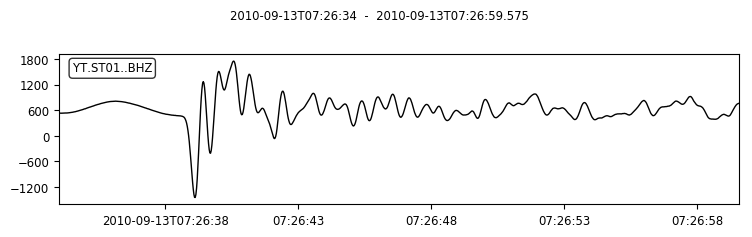

In [21]:
# raw data plot
stn[0].plot()

In [22]:
# Preprocessing 1
stp2 = stn.copy()                                                 # copy stream
t = stp2[0].stats.starttime
stp2.detrend('linear')                                          
stp2.taper(max_percentage=0.05, type='cosine')

2 Trace(s) in Stream:
YT.ST01..BHZ | 2010-09-13T07:26:34.000000Z - 2010-09-13T07:26:59.575000Z | 40.0 Hz, 1024 samples
YT.STT1..BHZ | 2010-09-13T07:26:34.000000Z - 2010-09-13T07:26:59.575000Z | 40.0 Hz, 1024 samples

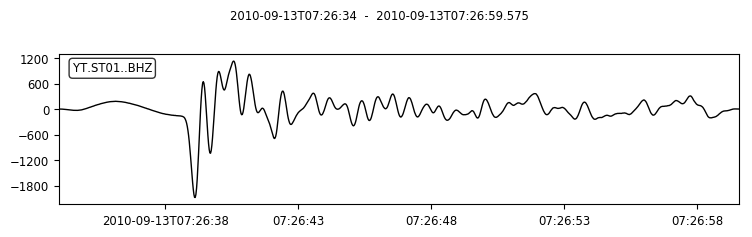

In [23]:
# after detrend and cosine taper
stp2[0].plot()

In [24]:
# 1 bit normalzation 
# then whitening; devonovolution bythe mean spetrca 

stw = stp2.copy()                            # copy stream
n = 1
for tr in stw:
    tr = normalize(tr, norm_method="1bit")
    #tr = whiten(tr, 0.1, 0.2)
    tr = whiten2(tr, 1, 5, 3)

    print(tr)
    #print(n)
    n += 1
    

print ('done!')


YT.ST01..BHZ | 2010-09-13T07:26:34.000000Z - 2010-09-13T07:26:59.575000Z | 40.0 Hz, 1024 samples
YT.STT1..BHZ | 2010-09-13T07:26:34.000000Z - 2010-09-13T07:26:59.575000Z | 40.0 Hz, 1024 samples
done!


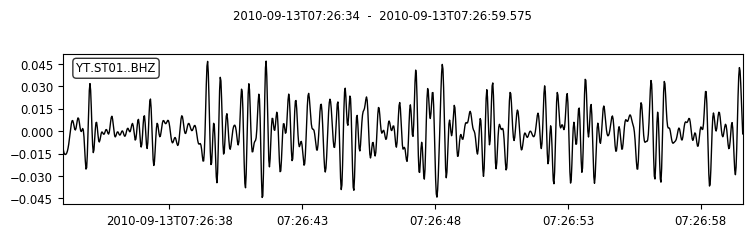

In [25]:
# 1-bit normalized and whitened waveforms
stw[0].plot()

In [26]:
# Cross-correlate
#xcorr_w, stack_w = correlateNoise(stw, ['MLAC','PHL'], 7200)
#xcorr_w, stack_w = correlateNoise(stw, ['ST01','STT1'], 12.75)
xcorr_w, stack_w = correlateNoise(stw, ['ST01','STT1'], 12.786)

#xcorr_w, stack_w = correlateNoise(stw, ['ST01','STT1'], 100)

correlating stations ('ST01', 'STT1')
2010-09-13T07:26:46.786000Z
2010-09-13T07:26:34.003000Z
# n =  1
...done


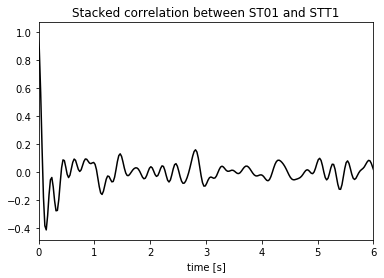

In [27]:
# Plotting
plotStack2(stw,stack_w,6)